In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tnrange, tqdm
from jax import random, vmap, jit, value_and_grad
from jax.experimental import optimizers, stax
import jax.numpy as np
import staxplusplus as spp
from normalizing_flows import *
import matplotlib.pyplot as plt
from datasets import *

In [3]:
from datasets import get_celeb_dataset

In [4]:
quantize_level_bits = 3
x_train = get_celeb_dataset(quantize_level_bits=quantize_level_bits, n_images=1000)
# x_train, train_labels, test_images, test_labels = get_cifar10_data(quantize_level_bits=quantize_level_bits)
x_train.shape

(1000, 32, 32, 3)

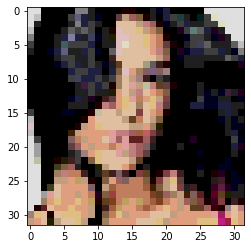

In [5]:
plt.imshow(x_train[1]/(2.0**quantize_level_bits))

# Build the RealNVP Model

In [15]:
import jax.nn.initializers

def Transform(out_shape, n_hidden_layers=4, layer_size=1024):
    out_dim = out_shape[-1]
    # Build the s and t networks that xb will be fed into
    layer_sizes = [layer_size for _ in range(n_hidden_layers)]
    log_s_out = spp.sequential(spp.Dense(out_dim), spp.Tanh())
    t_out = spp.sequential(spp.Dense(out_dim))
    dense_layers = [spp.Dense(layer_size), spp.Relu()]*n_hidden_layers
    coupling_param_architecture = spp.sequential(*dense_layers, spp.FanOut(2), spp.parallel(log_s_out, t_out))

    # Split x into xa, xb and feed xb into its path
    return coupling_param_architecture

def ResidualBlock(n_channels, name_prefix=''):
    
#     conv = spp.WeightNormConv
    conv = spp.Conv
    
    network = spp.sequential(conv(n_channels, filter_shape=(1, 1), padding=((0, 0), (0, 0)), name='%s_wn0'%name_prefix),
                             spp.Relu(name='%s_relu0'%name_prefix), 
                             conv(n_channels, filter_shape=(3, 3), padding=((1, 1), (1, 1)), name='%s_wn1'%name_prefix),
                             spp.Relu(name='%s_relu1'%name_prefix),
                             conv(n_channels, filter_shape=(1, 1), padding=((0, 0), (0, 0)), name='%s_wn2'%name_prefix))
    return spp.Residual(network)

def ResNet(out_shape, n_filters=32, n_blocks=6, name_prefix=''):
    height, width, channel = out_shape

#     conv = spp.WeightNormConv
    conv = spp.Conv
    
    res_blocks = [ResidualBlock(n_filters, name_prefix='%s_res_%d'%(name_prefix, i)) for i in range(n_blocks)]

    network = spp.sequential(conv(n_filters, filter_shape=(3, 3), padding=((1, 1), (1, 1)), name='%s_wn0'%name_prefix),
                             spp.Relu(name='%s_relu0'%(name_prefix)),
                             *res_blocks,
                             spp.Relu(name='%s_relu1'%(name_prefix)),
                             conv(2*channel, filter_shape=(3, 3), padding=((1, 1), (1, 1)), name='%s_wn1'%name_prefix, b_init=jax.nn.initializers.zeros))

    return spp.sequential(network, spp.Split(2, axis=-1), spp.parallel(spp.Tanh(), spp.Identity()))

def RealNVP(name_prefix=''):
    
    checker_transforms1 = sequential_flow(MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_0'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=False,
                                                               name='%s_coupling_0'%(name_prefix)),
                                          ActNorm(name='%s_an_0'%(name_prefix)),
                                          MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_1'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=True,
                                                               name='%s_coupling_1'%(name_prefix)),
                                          ActNorm(name='%s_an_1'%(name_prefix)),
                                          MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_2'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=False,
                                                               name='%s_coupling_2'%(name_prefix)),
                                          ActNorm(name='%s_an_2'%(name_prefix)),
                                          MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_3'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=True,
                                                               name='%s_coupling_3'%(name_prefix)),
                                          ActNorm(name='%s_an_3'%(name_prefix)))
    
    channel_transforms = sequential_flow(MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_4'%(name_prefix)), 
                                                              mask_type='channel_wise',
                                                              name='%s_coupling_4'%(name_prefix)),
                                         Reverse(),
                                         ActNorm(name='%s_an_4'%(name_prefix)),
                                         MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_5'%(name_prefix)), 
                                                              mask_type='channel_wise',
                                                              name='%s_coupling_5'%(name_prefix)),
                                         Reverse(),
                                         ActNorm(name='%s_an_5'%(name_prefix)),
                                         MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_6'%(name_prefix)), 
                                                              mask_type='channel_wise',
                                                              name='%s_coupling_6'%(name_prefix)),
                                         ActNorm(name='%s_an_9'%(name_prefix)))
    
    checker_transforms2 = sequential_flow(MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_7'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=False,
                                                               name='%s_coupling_7'%(name_prefix)),
                                          ActNorm(name='%s_an_6'%(name_prefix)),
                                          MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_8'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=True,
                                                               name='%s_coupling_8'%(name_prefix)),
                                          ActNorm(name='%s_an_7'%(name_prefix)),
                                          MaskedAffineCoupling(partial(ResNet, name_prefix='%s_AC_9'%(name_prefix)), 
                                                               mask_type='checkerboard', 
                                                               top_left_zero=False,
                                                               name='%s_coupling_9'%(name_prefix)),
                                          ActNorm(name='%s_an_8'%(name_prefix)))

    real_nvp = sequential_flow(checker_transforms1, 
                               OnebyOneConv(),
                               CheckerboardSqueeze(), 
                               OnebyOneConv(),
                               channel_transforms, 
                               OnebyOneConv(),
                               CheckerboardUnSqueeze(),
                               checker_transforms2)

    return real_nvp

z_dim = 100

def MultiScaleRealNVP():
    
    flow = sequential_flow(Dequantization(scale=2**quantize_level_bits), 
                           Logit(), 
                           RealNVP(name_prefix='realnvp_0'),
                           CheckerboardFactor(2),
                           factored_flow(sequential_flow(CheckerboardFactor(2),
                                                         factored_flow(RealNVP(name_prefix='realnvp_1'),
                                                                       sequential_flow(CheckerboardFactor(2),
                                                                                       factored_flow(RealNVP(name_prefix='realnvp_2'),
                                                                                                     Identity(), condition_on_results=False),
                                                                                       CheckerboardCombine(2)), condition_on_results=False),
                                                         CheckerboardCombine(2)),
                                         Identity(), condition_on_results=False),
                           CheckerboardCombine(2),
#                            Reshape((np.prod(x_train.shape[1:]),)),
#                            AffineGaussianPriorFullCov(z_dim))
                           UnitGaussianPrior(axis=(-3, -2, -1)))
    
    return flow

#     def gen_flow(n_coupling=4, n_dim_changes=8, start_dim=100, end_dim=600):
#         get_layers = lambda j : [sequential_flow(MaskedAffineCoupling(Transform), ActNorm(name='an_%d'%(j+i)), Reverse()) for i in range(4)]
    
#         dims = np.linspace(start_dim, end_dim, n_dim_changes).astype(np.int32)
#         flow = sequential_flow(*get_layers(0),
#                                AffineGaussianPriorFullCov(start_dim))
        
#         for i, dim in enumerate(dims):
#             if(i == 0):
#                 continue
#             flow = sequential_flow(*get_layers(n_coupling*i),
#                                    TallAffine(flow, dim))
    
#         flow = sequential_flow(Dequantization(scale=2**quantize_level_bits), 
#                                Logit(), 
#                                Reshape((np.prod(x_train.shape[1:]),)),
#                                TallAffine(flow, 600))
#         return flow


# #     flow = gen_flow()
    
# #     prior_flow = sequential_flow(*layers,
# #                                  AffineGaussianPriorFullCov(z_dim))

# #     flow = sequential_flow(Dequantization(scale=2**quantize_level_bits), 
# #                            Logit(), 
# #                            Reshape((np.prod(x_train.shape[1:]),)),
# #                            TallAffine(prior_flow, z_dim))

#     return flow

# Initialize the model

In [16]:
flow = MultiScaleRealNVP()
init_fun, forward, inverse = flow

key = random.PRNGKey(0)
names, output_shape, params, state = init_fun(key, x_train.shape[1:], ())
output_shape

(32, 32, 3)

In [ ]:
actnorm_names = [name for name in tree_flatten(names)[0] if 'an' in name]

# batch_size = 256
# seed_steps = 1000
batch_size = 8
seed_steps = 1500
flat_params, unflatten = ravel_pytree(params)
for i in tnrange(seed_steps):
    key, *keys = random.split(key, 3)
    
    # Get the next batch of data
    batch_idx = random.randint(keys[0], (batch_size,), minval=0, maxval=x_train.shape[0])
    x_batch = x_train[batch_idx,:]
    
    # Compute the seeded parameters
    new_params = flow_data_dependent_init(x_batch, actnorm_names, names, params, state, forward, (), 'actnorm_seed', key=key)

    # Compute a running mean of the parameters
    new_flat_params, _ = ravel_pytree(new_params)
    flat_params = i/(i + 1)*flat_params + new_flat_params/(i + 1)
    params = unflatten(flat_params)

# Create the loss function and optimizer

In [ ]:
@jit
def nll(params, state, x, **kwargs):
    cond = ()
    log_px, z, updated_state = forward(params, state, np.zeros(x.shape[0]), x, cond, **kwargs)
    return -np.mean(log_px), updated_state
#     flat_params, _ = ravel_pytree(params)
#     return -np.mean(log_px) + 0.005*np.linalg.norm(flat_params), updated_state

# Create the gradient function
valgrad = value_and_grad(nll, has_aux=True)
valgrad = jit(valgrad)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(0.0001)
opt_update = jit(opt_update)
opt_state = opt_init(params)

losses = []

# Train

In [ ]:
# batch_size = 256
batch_size = 8

pbar = tnrange(500000)
for i in pbar:
    key, *keys = random.split(key, 3)
    
    batch_idx = random.randint(keys[0], (batch_size,), minval=0, maxval=x_train.shape[0])
    x_batch = x_train[batch_idx,:]
    
    params = get_params(opt_state)
    (val, state), grad = valgrad(params, state, x_batch, key=keys[1], test=TRAIN)
#     if(np.isnan(val) or np.any(np.isnan(ravel_pytree(grad)[0]))):
#         assert 0, 'NaN loss'
    val = val/np.prod(x_train.shape[1:])
    opt_state = opt_update(i, grad, opt_state)
    
    losses.append(val)
    pbar.set_description('Negative Log Likelihood: %5.3f'%(val))
    
    if(i%1000 == 0):
        n_samples = 8
        eval_key = random.PRNGKey(2)
#         z = random.normal(eval_key, (n_samples, z_dim))*0.7
        z = random.normal(eval_key, (n_samples,) + x_train.shape[1:])
        _, fz, _ = inverse(params, state, np.zeros(n_samples), z, (), test=TEST)
        fz /= (2.0**quantize_level_bits) # Put the image (mostly) between 0 and 1

        n_cols = 8
        n_rows = int(np.ceil(n_samples/n_cols))

        fig, axes = plt.subplots(n_rows, n_cols); axes = axes.ravel()
        fig.set_size_inches(2*n_cols, 2*n_rows)

        for i, ax in enumerate(axes):
            ax.imshow(fz[i])
            
        plt.show()

In [ ]:
np.mean(fz), np.std(fz)

# Optionally, debug

In [ ]:
# name_leaves, name_tree = tree_flatten(names)
# param_leaves = name_tree.flatten_up_to(params)
# grad_leaves = name_tree.flatten_up_to(grad)

# for n, p, g in zip(name_leaves, param_leaves, grad_leaves):
#     print(n, p)

# Check the losses

In [ ]:
plt.plot(losses[400:])

In [ ]:
n_examples = 8

log_px, finvx, _ = forward(params, state, np.zeros(n_examples), x_train[:n_examples], (), test=TEST, key=key, sigma=0.0)
_, fz, _ = inverse(params, state, np.zeros(n_examples), finvx, (), test=TEST, key=key)
fz /= (2.0**quantize_level_bits)

for i in range(n_examples):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(fz[i])
    ax2.imshow(x_train[i]/(2.0**quantize_level_bits))
    plt.show()

In [ ]:
np.mean(finvx), np.std(finvx)

In [ ]:
n_samples = 48
z = random.normal(key, (n_samples, z_dim))*0.5
# z = random.normal(key, (n_samples,) + x_train.shape[1:])
_, fz, _ = inverse(params, state, np.zeros(n_samples), z, (), test=TEST)
fz /= (2.0**quantize_level_bits) # Put the image (mostly) between 0 and 1

n_cols = 8
n_rows = int(np.ceil(n_samples/n_cols))

fig, axes = plt.subplots(n_rows, n_cols); axes = axes.ravel()
fig.set_size_inches(3*n_cols, 3*n_rows)

for i, ax in enumerate(axes):
    ax.imshow(fz[i])

In [ ]:
def interpolate_pairs(index_pairs, n_points=20):
    
    n_cols = n_points
    n_rows = len(index_pairs)

    fig, axes = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(2*n_cols, 2*n_rows)
    
    for i, (idx1, idx2) in enumerate(index_pairs):
        x = x_train[[idx1, idx2]]
        _, finvx, _ = forward(params, state, np.zeros(2), x, (), test=TEST, key=key)
        finvx1, finvx2 = finvx
        interpolation_z = np.linspace(finvx1, finvx2, n_points)
        _, fz, _ = inverse(params, state, np.zeros(n_points), interpolation_z, (), test=TEST, key=key)
        fz /= (2.0**quantize_level_bits)
        for j in range(n_points):
            axes[i,j].imshow(fz[j])
    plt.show()

In [ ]:
n_pairs = 30
random_pairs = random.randint(key, (2*n_pairs,), minval=0, maxval=x_train.shape[0])
pairs_iter = iter(random_pairs)
image_pairs = [(next(pairs_iter), next(pairs_iter)) for _ in range(n_pairs)]
interpolate_pairs(image_pairs)